# Area Under What Curve?

When training a classifier, there are lots of ways to assess how "good" it is. One of the metrics most commonly reported is the area under the receiver-operator characteristic curve, known as the AUC, or AUROC, or ROC AUC...

Thinking about this recently, I refreshed my memory on why it is a useful and important quantity for evaluating a model, and I was also struck by how badly it's named. This notebook documents my ponderings.

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

# Binary Classification

In a binary classification problem, we are interested in determining which of two classes each example belongs to, based on other known quantities which characterise the example.

Call the label $y \in \{ 0, 1 \}$ and the features $x \in \mathcal{X}$, drawn from some data distribution $\pi(x, y) = \pi_{x|y}(x|y) \pi_y(y)$.

We will have a model which provides a function which takes a feature vector and produces a score $s \in \mathbb{R}$:

$$
s = m(x)
$$

Using this, we will make a classification decision based on whether or not the score exceeds some threshold $t \in \mathbb{R}$:

$$
z(s, t) = \begin{cases} 1 & s \geq t \\ 0 & s < t \end{cases}
$$

For each example to which we apply our model there are four possible outcomes, where the true label $y$ and estimated label $z$ may be each be $0$ or $1$.

The operation of classifier depends on three factors:
* The prevalence of the two classes, i.e. $\pi_y(y)$.
* How good the model is at separating the two classes in feature space
* Where we set the threshold

The important thing when calculating metrics to evaluate our classiier is that we clearly distinguish which of these factors we're trying to assess.

In [19]:
def generate_some_data(num_pos=1000, mn_pos=1.0, sd_pos=1.0, num_neg=1000, mn_neg=-1.0, sd_neg=1.0):
    x_pos = stats.t.rvs(3, loc=mn_pos, scale=sd_pos, size=num_pos)
    x_neg = stats.t.rvs(3, loc=mn_neg, scale=sd_neg, size=num_neg)
    x = np.concatenate((x_pos, x_neg))
    y = np.concatenate((np.ones(num_pos, dtype=bool), np.zeros(num_neg, dtype=bool)))
    return x[:, None], y

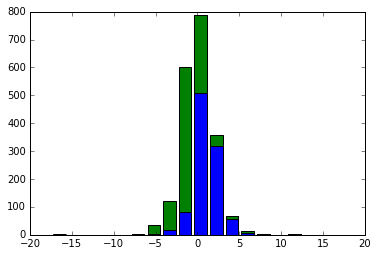

In [21]:
x, y = generate_some_data()
fig, ax = plt.subplots()
ax.hist((x[y], x[~y]), bins=20, stacked=True)
plt.show()

# Pairwise Ordering Probability

Suppose the thing we want to characterise is the model's ability to separate the two classes. To do this, we need some measure of performance which does not depend on the class distribution or the threshold we set.

* The need to be independent of the threshold means that we can only look at scores, not the final outcomes of the classifier. 
* The need to be independent of the class distribution means that whatever measure we come up with must be suitably conditioned on class. We could not, for example, use anything based on classifying a randomly chosen data point.

There is a convenient measure which satisfies these two properties. Suppose we take a random example from each class, and attempt to classify them together. Since we know we have exactly one example from each class, the only thing that matters is the score ordering. We'll infer that the example with the larger score is in class $1$ and the other one is in class $0$. The probability that we're correct is:

$$
p(m(\hat{x}) > m(\check{x}) \;|\; \hat{y}=1, \check{y}=0)
$$

Where $\hat{\cdot}$ and $\check{\cdot}$ denote variables associated with each of the two examples.

Why don't we call this POP, for pairwise ordering probability?

How to estimate POP? Well, we can get to it very easily with a Monte Carlo estimate.

\begin{align}
p(m(\hat{x}) > m(\check{x}) \;|\; \hat{y}=1, \check{y}=0) &= \int p(m(\hat{x}) > m(\check{x}), \hat{x}, \check{x} \;|\; \hat{y}=1, \check{y}=0) d\hat{x} d\check{x} \\
&= \int p(m(\hat{x}) > m(\check{x}) \;|\; \hat{x}, \check{x}) p(\hat{x} \;|\; \hat{y}=0) p(\check{x} \;|\; \check{y}=0) d\hat{x} d\check{x} \\
&= \int \mathbb{1}(m(\hat{x}) > m(\check{x})) p(\hat{x} \;|\; \hat{y}=0) p(\check{x} \;|\; \check{y}=0) d\hat{x} d\check{x} \\
&\leftarrow \frac{1}{N} \sum_i \mathbb{1}(m(\hat{x}_i) > m(\check{x}_i))
\end{align}

Where $\hat{x}_i$ and $\check{x}_i$ are samples drawn respectively from $\pi_{x|y}(\cdot|y=1)$ and $\pi_{x|y}(\cdot|y=0)$. So we can just randomly draw pairs of samples from our data, one from each class, and count how often the score for the $1$-class example is larger.

In [37]:
def sample_estimate_pop(x, y, N=1000):
    num_right = 0
    num_wrong = 0
    for i in range(N):
        pos_sample = x[np.random.choice(np.where(y)[0])]
        neg_sample = x[np.random.choice(np.where(~y)[0])]
        if (pos_sample > neg_sample):
            num_right += 1
        else:
            num_wrong += 1
    return num_right / (num_right + num_wrong)

In [48]:
print(sample_estimate_pop(x, y))

0.879


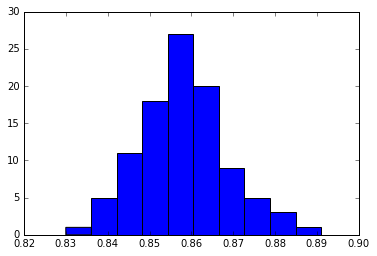

In [52]:
sample_estimate_arr = np.array([sample_estimate_pop(x, y) for k in range(100)])
fig, ax = plt.subplots()
ax.hist(sample_estimate_arr, bins=10)
plt.show()

# Should We Be Talking About FPRs And All That?

There's a better way. Let's do some manipulation of that probability.

